|Name:|Tufan Kundu|
|-|-|
|Registration no:|24MDT0184|
|Course Name:|Deep Learning Lab|
|Course Code:|PMDS603P|
|Experiment:|11|
|Date:|14 October,2025|

## Question 1

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, SimpleRNN, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)


2025-10-24 08:17:15.688890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761293836.123432     759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761293836.249005     759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
vocab_size = 10000     
maxlen = 500           
embedding_dim = 100    
val_size = 1000      

### Loading the dataset
(x_train_raw,y_train_raw),(x_test_raw,y_test_raw) = imdb.load_data(num_words=vocab_size)

lengths = [len(r) for r in x_train_raw+x_test_raw]
print("Min review length (words):", np.min(lengths))
print("Max review length (words):", np.max(lengths))
print("Mean review length (words):", int(np.mean(lengths)))

x_train_padded = pad_sequences(x_train_raw, maxlen = maxlen, padding = 'pre', truncating='pre')
x_test_padded = pad_sequences(x_test_raw, maxlen = maxlen, padding = 'pre', truncating='pre')

## Creating validation split

x_val = x_train_padded[:val_size]
y_val = np.array(y_train_raw[:val_size])

x_train = x_train_padded[val_size:]
y_train = np.array(y_train_raw[val_size:])

x_test = x_test_padded
y_test = np.array(y_test_raw)

print("\nShapes after padding and split:")
print("X_train:", x_train.shape,"y_train",y_train.shape)
print("X_val:", x_val.shape,"y_val",y_val.shape)
print("X_test:", x_test.shape,"y_test",y_test.shape)


Min review length (words): 70
Max review length (words): 2697
Mean review length (words): 469

Shapes after padding and split:
X_train: (24000, 500) y_train (24000,)
X_val: (1000, 500) y_val (1000,)
X_test: (25000, 500) y_test (25000,)


In [4]:
BiLSTM_model = Sequential()
BiLSTM_model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_shape=(maxlen,)))
BiLSTM_model.add(Bidirectional(LSTM(128, return_sequences=True)))
BiLSTM_model.add(Bidirectional(LSTM(64)))
BiLSTM_model.add(Dense(1, activation='sigmoid'))

BiLSTM_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
BiLSTM_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1761293854.890814     759 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761293854.891536     759 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,398,977 (5.34 MB)

 Trainable params: 1,398,977 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history_bilstm = BiLSTM_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,          
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/20


I0000 00:00:1761293862.825005     796 cuda_dnn.cc:529] Loaded cuDNN version 90300


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6893 - loss: 0.5663 - val_accuracy: 0.8660 - val_loss: 0.3362
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.8744 - loss: 0.3049 - val_accuracy: 0.8890 - val_loss: 0.2718
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.8914 - loss: 0.2707 - val_accuracy: 0.8780 - val_loss: 0.3179
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9224 - loss: 0.2030 - val_accuracy: 0.8610 - val_loss: 0.3414
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9394 - loss: 0.1633 - val_accuracy: 0.8610 - val_loss: 0.3654
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9534 - loss: 0.1281 - val_accuracy: 0.8650 - val_loss: 0.3818
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9552 - loss: 0.1201 - val_accuracy: 0.8750 - val_loss: 0.4145
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [6]:
loss_bilstm, acc_bilstm = BiLSTM_model.evaluate(x_test, y_test, verbose=1)
print(f"\nBi-LSTM Test Loss: {loss_bilstm:.4f}, Test Accuracy: {acc_bilstm:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8709 - loss: 0.3130

Bi-LSTM Test Loss: 0.3118, Test Accuracy: 0.8721


## Question 2: Next, build an Bi-GRU model and try the same problem and compare the outputs of the models.

In [7]:
BiGRU_model = Sequential()
BiGRU_model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_shape=(maxlen,)))
BiGRU_model.add(Bidirectional(GRU(128, return_sequences=True)))
BiGRU_model.add(Bidirectional(GRU(64)))
BiGRU_model.add(Dense(1, activation='sigmoid'))

BiGRU_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
BiGRU_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 500, 256)       │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,417 (4.96 MB)

 Trainable params: 1,300,417 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history_bigru = BiGRU_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,          
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.6687 - loss: 0.5861 - val_accuracy: 0.8210 - val_loss: 0.3948
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.8682 - loss: 0.3170 - val_accuracy: 0.8750 - val_loss: 0.3180
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9048 - loss: 0.2416 - val_accuracy: 0.8930 - val_loss: 0.2923
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9417 - loss: 0.1567 - val_accuracy: 0.8850 - val_loss: 0.3664
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9582 - loss: 0.1174 - val_accuracy: 0.8820 - val_loss: 0.3812
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9691 - loss: 0.0873 - val_accuracy: 0.8890 - val_loss: 0.3759
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9818 - loss: 0.0539 - val_accuracy: 0.8790 - val_loss: 0.4524
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9856 - loss: 0.0447 - 

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8755 - loss: 0.3214

Bi-GRU Test Loss: 0.3207, Test Accuracy: 0.8751

--- Comparison (Test set) ---
Bi-LSTM -> Loss: 0.3118, Acc: 0.8721
Bi-GRU  -> Loss: 0.3207, Acc: 0.8751


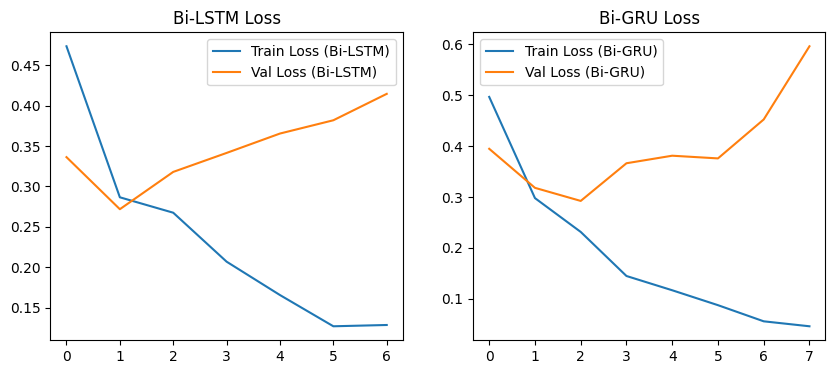

In [9]:
loss_bigru, acc_bigru = BiGRU_model.evaluate(x_test, y_test, verbose=1)
print(f"\nBi-GRU Test Loss: {loss_bigru:.4f}, Test Accuracy: {acc_bigru:.4f}")

print("\n--- Comparison (Test set) ---")
print(f"Bi-LSTM -> Loss: {loss_bilstm:.4f}, Acc: {acc_bilstm:.4f}")
print(f"Bi-GRU  -> Loss: {loss_bigru:.4f}, Acc: {acc_bigru:.4f}")



plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_bilstm.history['loss'], label='Train Loss (Bi-LSTM)')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss (Bi-LSTM)')
plt.legend(); plt.title('Bi-LSTM Loss')

plt.subplot(1,2,2)
plt.plot(history_bigru.history['loss'], label='Train Loss (Bi-GRU)')
plt.plot(history_bigru.history['val_loss'], label='Val Loss (Bi-GRU)')
plt.legend(); plt.title('Bi-GRU Loss')
plt.show()


## Questions 3: Think how you can create a simple model with RNN to predict the next word once you give a sentence to the model. Try to create one such model that can do this task. Use the same imdb dataset for the task. (Hint: Try to first prepare the sequences for training just like we did in gold price prediction, Sequences in which we have say 10 words as inputs and the next word as output. And we can plan like we can in our model the final layer with vocal size you have fixed that many number of neurons so that you can run with a softmax function to predict the probability of next word and train the model accordingly)

### Importing necessary libraries

In [10]:
import numpy as np 
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical

### Loading the dataset 

In [11]:
vocab_size = 5000
sequence_length = 10

(x_train,_),(_,_) = imdb.load_data(num_words = vocab_size)

all_words = [word for review in x_train for word in review]

sequences = []
next_words = []

for i in range(len(all_words) - sequence_length):
    seq = all_words[i:i+sequence_length]
    next_word = all_words[i+sequence_length]
    sequences.append(seq)
    next_words.append(next_word)

sequences = np.array(sequences)
next_words = to_categorical(next_words, num_classes = vocab_size)

print("Input shape:", sequences.shape)
print("Output shape:", next_words.shape)

Input shape: (5967831, 10)
Output shape: (5967831, 5000)


In [12]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_shape=(sequence_length,)))
model.add(SimpleRNN(128))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 10, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        22,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5000)           │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 917,912 (3.50 MB)

 Trainable params: 917,912 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model.fit(sequences[:50000], next_words[:50000], epochs=50, batch_size=128, callbacks = [es], verbose = 1)


Epoch 1/50


I0000 00:00:1761294434.450323     795 service.cc:148] XLA service 0x7867040d2a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761294434.455911     795 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761294434.455936     795 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 42/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0661 - loss: 7.8775

I0000 00:00:1761294436.150933     795 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0992 - loss: 6.5719
Epoch 2/50
 43/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1027 - loss: 5.9133

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1123 - loss: 5.8558
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1321 - loss: 5.6136
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1489 - loss: 5.3731
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1590 - loss: 5.1967
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1648 - loss: 5.0751
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1677 - loss: 4.9613
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1721 - loss: 4.8832
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1749 - loss: 4.7759
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1801 - loss: 4.6786
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1844 - loss: 4.5799
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1911 - loss: 4.4808
Epoch 13/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accurac

In [21]:
word_index = imdb.get_word_index()

index_word = {index + 3: word for word, index in word_index.items() if index+3 < vocab_size}
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'

In [30]:
def predict_next_word(model, seed_seq, index_word, sequence_length=10):
    
    seq_input = pad_sequences([seed_seq], maxlen=sequence_length)
    
    pred_probs = model.predict(seq_input, verbose=0)[0]
    
    next_word_index = np.argmax(pred_probs)
    
    next_word = index_word.get(next_word_index, '<UNK>')
    
    return next_word

In [33]:
num_samples = 5  # number of sequences to test
seed_sequences = [all_words[i:i+sequence_length] for i in range(num_samples)]

# Convert seed sequences to actual words for display
seed_words_list = [[index_word.get(idx, '<UNK>') for idx in seq] for seq in seed_sequences]


predicted_next_words = []

for seq in seed_sequences:
    next_word = predict_next_word(model, seq, index_word, sequence_length=sequence_length)
    predicted_next_words.append(next_word)


for i in range(num_samples):
    print(f"Seed sequence {i+1}: {' '.join(seed_words_list[i])}")
    print(f"Predicted next word: {predicted_next_words[i]}")
    print("-" * 50)


Seed sequence 1: <START> this film was just brilliant casting location scenery story
Predicted next word: as
--------------------------------------------------
Seed sequence 2: this film was just brilliant casting location scenery story direction
Predicted next word: everyone's
--------------------------------------------------
Seed sequence 3: film was just brilliant casting location scenery story direction everyone's
Predicted next word: be
--------------------------------------------------
Seed sequence 4: was just brilliant casting location scenery story direction everyone's really
Predicted next word: suited
--------------------------------------------------
Seed sequence 5: just brilliant casting location scenery story direction everyone's really suited
Predicted next word: to
--------------------------------------------------
